# CMSC 320 FINAL PROJECT: WHAT COUNTRY HAS THE GREATEST NATIONAL FOOTBALL(SOCCER) team_home?
Owners: Nathaniel Bekele and Mikias Atnafu

## Introduction:
First and foremost, we will be establishing what we believe to be the most important boundary for this project, we will be referring to the sport exclusively as football not soccer.

The data we will be using was compiled by Mart Jürisoo and is available on Kaggle: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017?resource=download.

## Factors to be considered:
### Time period
This dataset has all the results of international football fixtures from 1872 to 2022. While it would be amazing to consider the data from 1872, we also thought of the possibility that it would be rather unfair on most countries that were colonized at the time and hence did not have a national team to compete with. Thus we will be limiting the data to 1976 to 2022 

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Data Preprocessing
Before we start analysing who is the greatest national football team, we need to preproces the data. So, lets first read the csv file into a panda dataframe. We have used two data set, The first one is the international football result, and the second one is the football world cup summary, which will help us to see who reached the final and who won the world cup over the year starting from 1975.    

### Reading the first data, *The international football result*

In [3]:
football_df = pd.read_csv('results.csv')


# Create column Year using the year in the date column
football_df['year'] = football_df['date'].str.extract('(\d\d\d\d)')


# Change column Year to type int
football_df['year'] = football_df['year'].astype(int)

# filter only the data with year >= 1975 
football_df = football_df[football_df['year'] >= 1975]

football_df.head() 


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
9353,1975-01-01,Cameroon,Guinea,1,0,Friendly,Yaoundé,Cameroon,False,1975
9354,1975-01-01,Iraq,Tunisia,0,0,Friendly,Baghdad,Iraq,False,1975
9355,1975-01-03,Bermuda,Suriname,2,5,Friendly,Hamilton,Bermuda,False,1975
9356,1975-01-05,Cuba,Canada,4,0,Friendly,Havana,Cuba,False,1975
9357,1975-01-09,Iraq,Libya,3,1,Friendly,Baghdad,Iraq,False,1975


### Reading the second data, *World Cup Summary*

In [4]:
# read the FIFA world cup summary and display the first 5 rows 
world_cup_summary = pd.read_csv('FIFA-World Cup Summary.csv')

# filters the dataset by taking the world cup after the year 1975 
world_cup_summary = world_cup_summary[world_cup_summary['YEAR'] >= 1975]
world_cup_summary.head()

,YEAR,HOST,CHAMPION,RUNNER UP,THIRD PLACE,TEAMS,MATCHES PLAYED,GOALS SCORED,AVG GOALS PER GAME
10,1978,Argentina,Argentina,Netherlands,Brazil,16,38,102,2.7
11,1982,Spain,Italy,West Germany,Poland,24,52,146,2.8
12,1986,Mexico,Argentina,West Germany,France,24,52,132,2.5
13,1990,Italy,West Germany,Argentina,Italy,24,52,115,2.2
14,1994,United States,Brazil,Italy,Sweden,24,52,141,2.7


## Tyding the data
The tournament column contains very many tornaments (177 to be specefic), for this project we will only focus on the world cup, so we will only be working with the worldcup tournament.
Also, to make the analysis convenient, we will add serval columns into our dataframe suchas Winning percentage, Number of losses, Number of matches played any a few others. Using these columns, we can better analysis the best national team. The code below will do just that, adding the necessary columns.  

In [5]:
# Filter only the FIFA World Cup tournment
FIFA_WC = football_df[football_df['tournament'] == 'FIFA World Cup'].copy()
FIFA_WC.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
10650,1978-06-01,Germany,Poland,0,0,FIFA World Cup,Buenos Aires,Argentina,True,1978
10651,1978-06-02,Argentina,Hungary,2,1,FIFA World Cup,Buenos Aires,Argentina,False,1978
10652,1978-06-02,France,Italy,1,2,FIFA World Cup,Mar del Plata,Argentina,True,1978
10653,1978-06-02,Mexico,Tunisia,1,3,FIFA World Cup,Rosario,Argentina,True,1978
10654,1978-06-03,Austria,Spain,2,1,FIFA World Cup,Buenos Aires,Argentina,True,1978


In the code below, we are going to group the dataset by the teams and create a column for the goal scored and goal conceeded for each team
The goal scored column will help us to see which team is good at attacking, whereas the goal conceeded tell us about the teams defense strength. For convenience we will combine the home_team and away_team so that we will have a new dataframe 
with only the necessary rows. There are two teams (El Salvador and Kuwait) that are in away_team but not in home team therefore, we don't consider this two teams when getting the team information from the home_team.

In [6]:

team_group_home = FIFA_WC.groupby(by='home_team')    # group the data by home_team
team_group_away = FIFA_WC.groupby(by='away_team')    # group the data by away_team

In [35]:
clean_data = {'country':[], 'win_percentage':[], 'match_played':[], 'match_won':[], 'match_lost':[],
              'goal_scored':[], 'goal_conceded':[], 'avg_goal_score_per_match':[]}

# add the team names of the home_team and away_team 
team_name = list(FIFA_WC['home_team'].unique())
team_name.extend(t for t in list(FIFA_WC['away_team'].unique()) if not t in team_name)

# iterate over each team and get the necessary information to create a new dataframe
for current_team in team_name:
    goal_scored = goal_conceded = 0
    if current_team != 'El Salvador' and current_team != 'Kuwait':
        team_home = team_group_home.get_group(current_team)    # a single team from a home_team  
        # number of time won while a home team
        num_won_home = len(team_home[team_home['home_score']  > team_home['away_score']])
        goal_scored = team_home['home_score'].sum() 
        goal_conceded = team_home['away_score'].sum() 
    else: # we found the two teams that are not in home_team
        num_won_home = 0
        team_home = []

    # a single team from an away_team
    team_away = team_group_away.get_group(current_team)         
    # number of time won while an away team
    num_won_away = len(team_away[team_away['away_score']  > team_away['home_score']])
    goal_scored += team_away['away_score'].sum()
    goal_conceded += team_away['home_score'].sum() 

    total_num_won = num_won_home + num_won_away
    total_num_played = len(team_home) + len(team_away)
    win_per =  total_num_won / total_num_played

    # append the row to the dictionary which later be converted to a dataframe
    clean_data['country'].append(current_team)
    clean_data['match_played'].append(total_num_played)
    clean_data['match_won'].append(total_num_won)
    clean_data['match_lost'].append(total_num_played - total_num_won)
    clean_data['win_percentage'].append(win_per)
    clean_data['goal_scored'].append(goal_scored)
    clean_data['goal_conceded'].append(goal_conceded)
    clean_data['avg_goal_score_per_match'].append(goal_scored / total_num_played)


# create a new dataframe using the clean data
tidy_data = pd.DataFrame(clean_data)
tidy_data.head()

,country,win_percentage,match_played,match_won,match_lost,goal_scored,goal_conceded,avg_goal_score_per_match
0,Germany,0.588235,68,40,28,126,62,1.852941
1,Argentina,0.576271,59,34,25,97,54,1.644068
2,France,0.551020,49,27,22,82,44,1.673469
3,Mexico,0.361111,36,13,23,41,48,1.138889
4,Austria,0.352941,17,6,11,17,21,1.000000


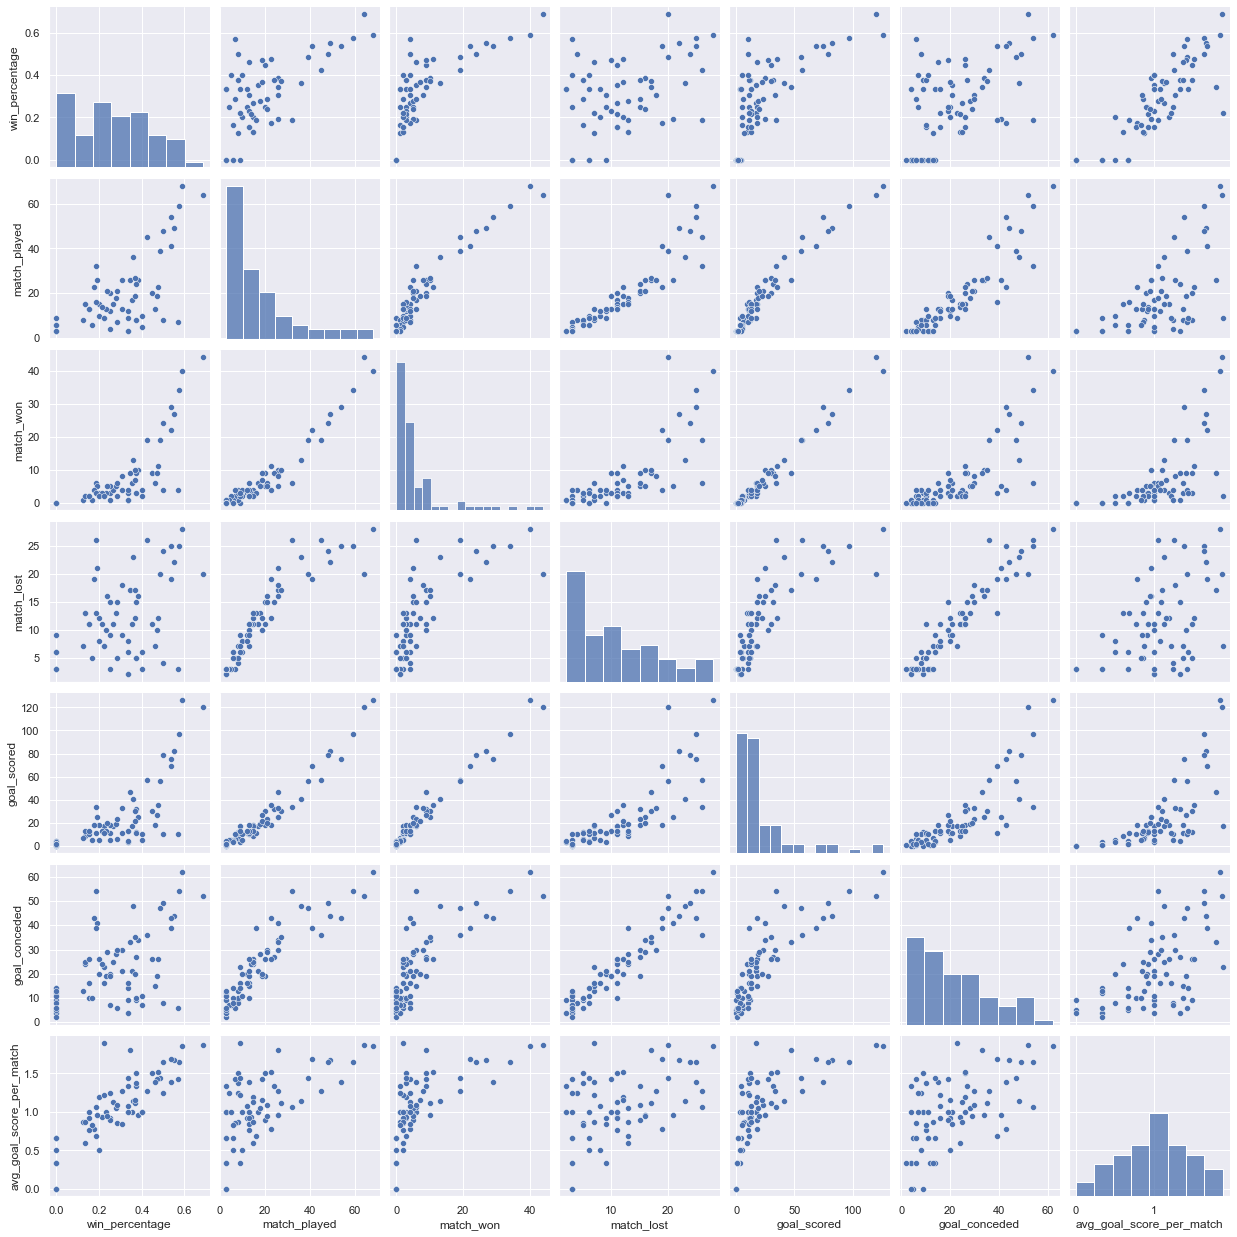

In [40]:
sns.pairplot(data=tidy_data)
plt.show()